## Imports

In [1]:
import sys, os
import pandas as pd
import polars as pl
import numpy as np
from dotenv import load_dotenv

sys.path.append('/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting')
# when running on JupyterHub the dot-env-path needs to be adapted
load_dotenv("../.env")

datetime_format = "%Y-%m-%d %H:%M%z"

%load_ext autoreload

In [23]:
%autoreload

## Calculate Region Proportions

what are the weights of the regions of the smart meter locations

and what weather stations and weather forecast grid points can we utilize for a weighted forecast

## Checking data shapes

In [13]:
df = pd.read_csv('../data/2023_05_cleaned_pv.csv', parse_dates=True).set_index('readingdate')
df_06 = pd.read_csv('../data/2023_06_cleaned_pv.csv', parse_dates=True).set_index('readingdate')
assert not df.isna().any().any()


In [17]:
df.index.is_monotonic_increasing, df_06.index.is_monotonic_increasing

(True, True)

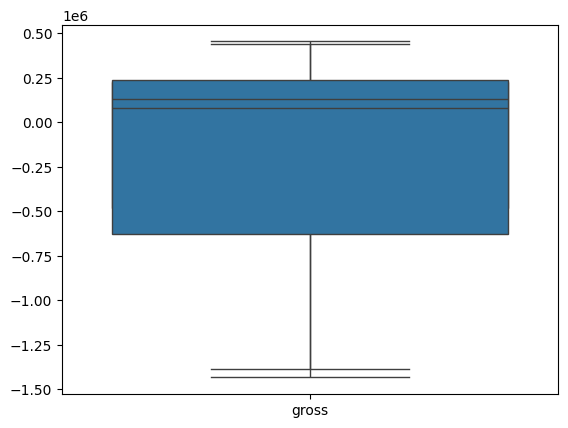

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df)
sns.boxplot(data=df_06)
plt.show()

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
print(scaled_df.min(), scaled_df.max())

0.0 1.0


AttributeError: 'numpy.ndarray' object has no attribute 'isna'

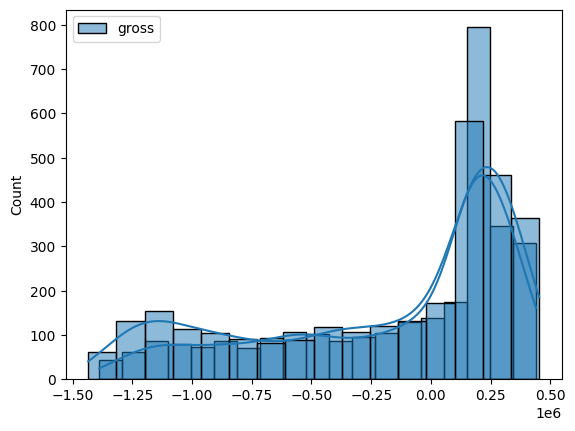

In [14]:
sns.histplot(df, kde=True)
sns.histplot(df_06, kde=True)
plt.show()

## Loading and Cleaning data

In [23]:
from neuro_symbolic_demand_forecasting.darts.cleaning import *
import pandas as pd
import polars as pl
import pytz
# df = pl.read_csv('./p4_data_june_2023.csv', columns=['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE'],
# df = pl.read_csv('../unclean_data/2023_05_data.csv', columns=['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE'],
# df = pl.read_csv('../unclean_data/2023_06_data.csv', columns=['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE'],
df = pl.read_csv('../unclean_data/2023_07_data_new_new.csv', columns=['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE'],
                 try_parse_dates=True,
                 new_columns=[f.lower() for f in ['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE']])

df = df.with_columns(pl.col("readingdate").str.to_datetime("%m/%d/%Y %I:%M:%S %p %z"))
df = df.sort('readingdate')
# df = df.with_columns(pl.col('readingdate').dt.convert_time_zone('Europe/Amsterdam'))
df

ean_sha256,ldn,odn,readingdate
str,f64,f64,"datetime[μs, UTC]"
"""D7F787FBA7E981…",4.0429141e7,2.8428972e7,2023-06-29 22:00:00 UTC
"""26824FAEB4B7EB…",6.23234e6,7.162845e6,2023-06-29 22:00:00 UTC
"""A863F790A9AE96…",2.4290178e7,1.3216095e7,2023-06-29 22:00:00 UTC
"""36A1C6DB5107DA…",2.1996397e7,5.0,2023-06-29 22:00:00 UTC
"""D0B21409E7FA78…",9.198359e6,0.0,2023-06-29 22:00:00 UTC
…,…,…,…
"""7E04B13C075DFA…",2.8947945e7,5.772971e6,2023-08-01 21:45:00 UTC
"""703FCE4B321566…",9.101156e6,0.0,2023-08-01 21:45:00 UTC
"""8DA949449F5282…",8.527058e6,6.890953e6,2023-08-01 21:45:00 UTC


In [4]:
df['ean_sha256'].unique() # 5631 old , 5456 new (old), NEW: 6_956, NEW NEW: 8_456

# june 2023 5_207

ean_sha256
str
"""CE725FC740A735…"
"""C4AAF23B70FB4E…"
"""1FCEA702B748E8…"
"""30871F83627646…"
"""7829BC737FFFB1…"
…
"""9D44B4A4242E7F…"
"""45BDD116D253E5…"
"""852125AAE8398E…"


### Dividing data into PV and non-PV cluster

In [ ]:
%autoreload

In [24]:
sum_odn = df.group_by('ean_sha256').agg(pl.col('odn').sum())

pv = df.filter(pl.col('ean_sha256').is_in(sum_odn.filter(pl.col('odn') > 0)['ean_sha256']))
non_pv = df.filter(pl.col('ean_sha256').is_in(sum_odn.filter(pl.col('odn') <= 0)['ean_sha256']))

print(pv, non_pv)
len(pv) + len(non_pv), len(df)

shape: (13_450_239, 4)
┌───────────────────────────────────┬─────────────┬─────────────┬─────────────────────────┐
│ ean_sha256                        ┆ ldn         ┆ odn         ┆ readingdate             │
│ ---                               ┆ ---         ┆ ---         ┆ ---                     │
│ str                               ┆ f64         ┆ f64         ┆ datetime[μs, UTC]       │
╞═══════════════════════════════════╪═════════════╪═════════════╪═════════════════════════╡
│ D7F787FBA7E981196BB9DFD64A14152A… ┆ 4.0429141e7 ┆ 2.8428972e7 ┆ 2023-06-29 22:00:00 UTC │
│ 26824FAEB4B7EB9524F5F911B83DD232… ┆ 6.23234e6   ┆ 7.162845e6  ┆ 2023-06-29 22:00:00 UTC │
│ A863F790A9AE963F1472C52BDA9D2722… ┆ 2.4290178e7 ┆ 1.3216095e7 ┆ 2023-06-29 22:00:00 UTC │
│ 36A1C6DB5107DACAACA38EAD70020E65… ┆ 2.1996397e7 ┆ 5.0         ┆ 2023-06-29 22:00:00 UTC │
│ B161A75A339FC933F497613FE5D361CB… ┆ 2.5612321e7 ┆ 1.1107597e7 ┆ 2023-06-29 22:00:00 UTC │
│ …                                 ┆ …           ┆ …    

(23023628, 23023628)

In [19]:
# May pv, non_pv, (0.62, 0.38)
# June pv, non_pv, (0.62, 0.38)
# July pv, non_pv, (0.58, 0.42)
round(len(pv) / len(df), 2), round(len(non_pv) / len(df), 2) 

(0.58, 0.42)

In [20]:
(0.62 + 0.62 + 0.58)/ 3, (0.38 + 0.38 + 0.42)/ 3

(0.6066666666666666, 0.3933333333333333)

### Cleaning dfs

In [16]:
%autoreload

In [26]:
# pv.plot()


i = 2784
# i = 2976 
# i = 1056
# p = pv['gross'][i-1]
# n = pv['gross'][i+1]
# pv[i, 'gross'] = (n + p ) / 2
# print((n + p ) / 2)
# print(pv[i])
pv.plot()
pv.write_csv('../data/2023_07_cleaned_pv_rework.csv')

In [25]:
cleaned_nonpv_df = clean_data(non_pv)
cleaned_nonpv_df.plot()

# old_nonpv = pl.read_csv('../data/2023_07_cleaned_non_pv.csv',
#                  try_parse_dates=True)

Filtering out 2023-08-01 21:45:00+00:00 2023-06-29 22:00:00+00:00 3168.0
Filtering out timeseries with less than 3168.0
Connections with missing values ! 4135 4116 19
Generating intervals
Aggregating data into one timeseries: cols: gross
Checking for outliers above 248167.7088 and below 11023.691250000003
3168 71
Linearly interpolation outliers detected at the indices: shape: (71,)
Series: 'index' [u32]
[
	0
	264
	265
	266
	267
	…
	3048
	3049
	3050
	3052
	3146
]


:Curve   [index]   (gross)

In [26]:
cleaned_pv_df = clean_data(pv)
cleaned_pv_df.plot()

Filtering out 2023-08-01 21:45:00+00:00 2023-06-29 22:00:00+00:00 3168.0
Filtering out timeseries with less than 3168.0
Connections with missing values ! 4321 4292 29
Generating intervals
Aggregating data into one timeseries: cols: gross
Checking for outliers above 972744.8500000001 and below -1817902.625
3168 22
Linearly interpolation outliers detected at the indices: shape: (22,)
Series: 'index' [u32]
[
	288
	576
	727
	728
	729
	…
	2496
	2592
	2745
	3029
	3033
]


:Curve   [index]   (gross)

In [53]:
month  = '07'

cleaned_pv_df.write_csv(f'../data/2023_{month}_cleaned_pv_rework.csv')
cleaned_nonpv_df.write_csv(f'../data/2023_{month}_cleaned_non_pv_rework.csv')

In [46]:
from darts import TimeSeries

nonpv_ts = TimeSeries.from_dataframe(cleaned_nonpv_df.to_pandas().set_index('readingdate'))


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/darts/timeseries.py:737: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

## Pulling weather data

In [3]:
actuals = pl.read_csv('./2023-06-amsterdam-actuals.csv')

actuals.columns

actual_cols = [ pl.col(c) for c in [
 'datetime_from',
 'wind_speed',
 'wind_gust_speed',
 'air_temperature',
 'relative_humidity',
 'air_pressure',
 'visibility',
#  'rain_gauge_precipitation_duration',
 'cloud_cover',
#  'pws_precipitation_intensity',
#  'pws_precipitation_duration',
 'global_radiation',
 'dew_point_temperature',
 ]]

selected_actuals = actuals.select(actual_cols)
selected_actuals = selected_actuals.with_columns(pl.col('datetime_from').str.to_datetime())
selected_actuals

datetime_from,wind_speed,wind_gust_speed,air_temperature,relative_humidity,air_pressure,visibility,cloud_cover,global_radiation,dew_point_temperature
datetime[μs],f64,f64,f64,f64,f64,f64,str,f64,f64
2023-06-01 00:00:00,5.23,7.65,284.45,0.85,102491.0,31500.0,null,0.0,282.15
2023-06-01 00:10:00,5.28,8.62,284.55,0.85,102481.0,32200.0,null,0.0,282.15
2023-06-01 00:20:00,5.87,8.84,284.55,0.86,102471.0,26600.0,null,0.0,282.25
2023-06-01 00:30:00,6.16,9.28,284.45,0.86,102471.0,27600.0,null,0.0,282.25
2023-06-01 00:40:00,5.85,9.17,284.35,0.86,102471.0,26600.0,null,0.0,282.15
…,…,…,…,…,…,…,…,…,…
2023-07-29 23:10:00,4.62,6.35,289.85,0.88,100772.0,14900.0,"""2.0""",0.0,287.85
2023-07-29 23:20:00,5.15,6.55,289.95,0.87,100772.0,14300.0,"""6.0""",0.0,287.85
2023-07-29 23:30:00,4.9,6.12,289.95,0.87,100782.0,15000.0,"""8.0""",0.0,287.95


In [4]:
weather_df = pl.read_csv('../2023_weather_data_06_run_summer.csv', try_parse_dates=True).sort('valid_datetime')#.filter((pl.col('valid_datetime') < max_date) & (pl.col('valid_datetime') >= min_date))

selected_weather = weather_df.select(
    pl.col('valid_datetime'), pl.col('wind_speed_10m'), pl.col('t_instant_ground_2m'),  
    pl.col('grad_accum_ground_0m'),  pl.col('rain_instant_ground_0m'), pl.col('pres_instant_ground_0m'),
    pl.col('wind_blast_speed_10m')
)
selected_weather

# selected_weather.with_columns(pl.col('grad_accum_ground_0m') < 0).select(pl.col('valid_datetime'), pl.col('grad_accum_ground_0m'))

valid_datetime,wind_speed_10m,t_instant_ground_2m,grad_accum_ground_0m,rain_instant_ground_0m,pres_instant_ground_0m,wind_blast_speed_10m
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64
2023-04-01 00:00:00 UTC,5.08021,282.15723,0.0,0.00009,98975.19,10.466365
2023-04-01 01:00:00 UTC,4.670426,282.03906,0.0,0.000083,98986.19,9.381132
2023-04-01 02:00:00 UTC,4.5113754,281.7544,0.0,0.000088,98998.44,8.600689
2023-04-01 03:00:00 UTC,4.049578,281.49512,0.0,0.000094,99022.5,8.31484
2023-04-01 04:00:00 UTC,3.5291646,281.38184,0.0,0.000231,99044.81,7.4436874
…,…,…,…,…,…,…
2023-07-31 19:00:00 UTC,4.1694837,290.3694,25900.188,0.000036,100127.75,8.043049
2023-07-31 20:00:00 UTC,3.9396036,290.45752,890.4375,1.1921e-7,100079.75,7.7695036
2023-07-31 21:00:00 UTC,3.7858133,290.16504,0.0,0.0,100024.5,7.3689775


In [24]:
selected_weather.plot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

## Data Prep

In [91]:
cleaned_df.write_csv('2023_06_cleaned_data.csv')

## Py Torch Settings 

### Custom Loss

In [56]:
import torch
import torch.nn as nn

# Define your custom loss function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        # Define your loss components here

    def forward(self, output, target):
        # Calculate your custom loss
        # print('outputted', output)
        # print('target', target)
        loss = torch.mean((output - target)**2)  # Example custom loss (MSE)
        return loss
    

torch_kwargs = {
    'loss_fn': CustomLoss()
}


### Early stopping

In [12]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper]}

## LSTM with Darts

In [35]:
from darts.models import (
    NBEATSModel,
    BlockRNNModel
)

model_name = "BlockRNN_test"
model_lstm = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=4,
    n_epochs=10,
    random_state=0,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    **torch_kwargs
)

In [38]:
model_lstm.fit(
    train_meter,
    past_covariates=weather_ts,
    val_series=val_meter,
    val_past_covariates=weather_ts,
    # future_covariates=actuals_ts
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `BlockRNNModel.load_weights()` to load the weights for fine-tuning.
/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/notebooks/darts_logs/BlockRNN_test/checkpoints exists and is not empty.

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CustomLoss       | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.4 K 
4 | fc            | S

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=24, output_chunk_length=4, n_epochs=10, random_state=0, model_name=BlockRNN_test, save_checkpoints=True, force_reset=True, loss_fn=CustomLoss())

### Evaluation

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 29.01%
SMAPE = 22.99%
MAE = 0.12%


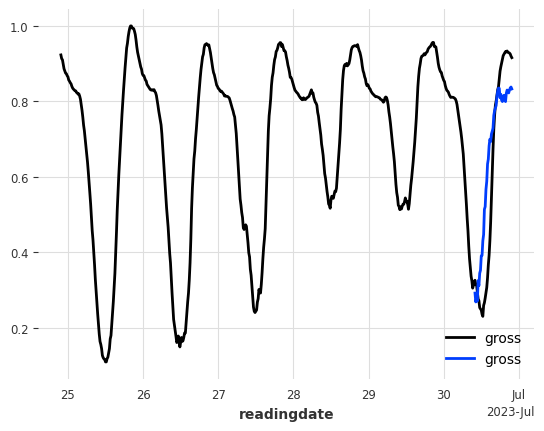

In [62]:
from darts.metrics import mape, smape, mae

# regr_model.predict(1)
# eval_model(regr_model, val_weather)

# plot acutals against the predicted horizon
forecast, actual  = val_meter[:-48], val_meter[-48:]

val_meter.plot()

pred = model_lstm.predict(48, forecast, weather_ts)
pred.plot()

print("MAPE = {:.2f}%".format(mape(actual, pred)))
print("SMAPE = {:.2f}%".format(smape(actual, pred)))
print("MAE = {:.2f}%".format(mae(actual, pred)))


## TFTModel



In [83]:
from darts.models import TFTModel
from darts import TimeSeries


input_chunk_length = 5 * 24 * 4
forecast_horizon = 1 * 24 * 4
# use `add_encoders` as we don't have future covariates
# from Paper
# model = TFTModel(
#     input_chunk_length=input_chunk_length, # encoder_length
#     output_chunk_length=forecast_horizon,
#     num_attention_heads=2,
#     hidden_size=60,
#     hidden_continuous_size=30,
#     lstm_layers=2,
#     batch_size=1024,
#     n_epochs=5,
#     dropout=0.7,
#     # add_encoders={"cyclic": {"future": ["month"]}},
#     add_relative_index=False,
#     optimizer_kwargs={"lr": 0.001}, # learning rate
#     use_static_covariates=False,
#     random_state=42,
# )

model= TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    # hidden_size=32,
    # lstm_layers=2,
    # batch_size=16,
    n_epochs=5,
    # dropout=0.1,
    # add_encoders={"cyclic": {"future": ["month"]}},
    # use_static_covariates=False,
    # add_relative_index=False,
    # optimizer_kwargs={"lr": 1e-3},
    random_state=42,
    use_static_covariates=False,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    **torch_kwargs # custom loss
)

### Training

In [37]:
print(train_meter.time_index.min(), train_meter.time_index.max())
print(weather_ts.time_index.min(), weather_ts.time_index.max())
print(actuals_ts.time_index.min(), actuals_ts.time_index.max())

2023-06-01 00:00:00 2023-06-24 21:30:00
2023-04-01 00:00:00 2023-07-31 23:00:00
2023-06-01 00:00:00 2023-07-29 23:45:00


In [81]:
actuals_ts.columns, weather_ts.columns

(Index(['wind_speed', 'wind_gust_speed', 'air_temperature', 'relative_humidity',
        'air_pressure', 'visibility', 'cloud_cover', 'global_radiation',
        'dew_point_temperature'],
       dtype='object', name='component'),
 Index(['wind_speed_10m', 't_instant_ground_2m', 'grad_accum_ground_0m',
        'rain_instant_ground_0m', 'pres_instant_ground_0m',
        'wind_blast_speed_10m'],
       dtype='object', name='component'))

In [17]:
# train_meter = train_meter[12:]
# weather_ts = weather_ts[:8496]
# weather_ts = weather_ts[5856:]
# len(train_meter), len(weather_ts[:8496]), len(actuals_ts)

In [84]:
dummy_covariate = pd.Series(0, index=train_meter.time_index)  # Adjust the constant value as needed


wts = weather_ts[['wind_speed_10m', 'grad_accum_ground_0m', 'pres_instant_ground_0m', 't_instant_ground_2m']]
ats = actuals_ts[['wind_speed', 'global_radiation', 'air_pressure', 'air_temperature']]
model.fit(
    train_meter, 
    past_covariates=ats, 
    future_covariates=wts, 
    val_series=val_meter,
    val_past_covariates=ats,
    
    val_future_covariates=wts, 
    verbose=True,
    
    # trainer=pl_trainer_kwargs
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | CustomLoss                       | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 5.9 K 
6  | decoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
7  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
8  | static_cont

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=CustomLoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=False, input_chunk_length=480, output_chunk_length=96, n_epochs=5, random_state=42, save_checkpoints=True)

### Evaluation

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 13.96%
SMAPE = 12.42%
MAE = 0.06%


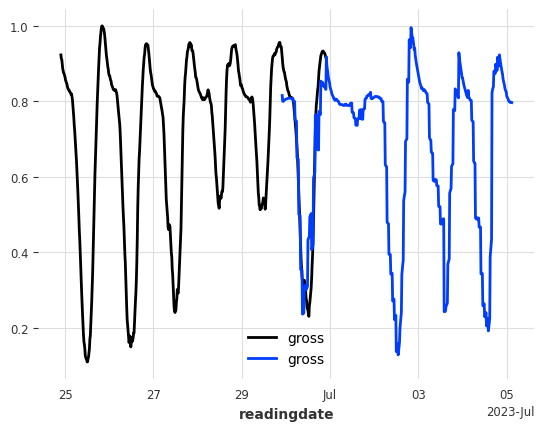

In [87]:
from darts.metrics import mape, smape, mae

# regr_model.predict(1)
# eval_model(regr_model, val_weather)

# plot acutals against the predicted horizon
forecast, actual  = val_meter[:-96], val_meter[-96:]
# train_meter.plot()
val_meter.plot()

pred = model.predict(n=500, series=forecast, past_covariates=ats, future_covariates=wts)
pred.plot()

print("MAPE = {:.2f}%".format(mape(actual, pred)))
print("SMAPE = {:.2f}%".format(smape(actual, pred)))
print("MAE = {:.2f}%".format(mae(actual, pred)))

## Evaluate an existing model

In [ ]:
# WAPE formula for df
wape = (df.Actual - df.Forecasted).abs().sum() / df.Actual.sum()

In [24]:
import sys
import pandas as pd
from darts.timeseries import TimeSeries

from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import pytz
import pickle

sys.path.append('/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting')

from src.neuro_symbolic_demand_forecasting.encoders.encoders import AMS_TZ


In [1]:
path = "/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/01_results/20240606_1124_tft_baseline"

# ts_semantic = TimeSeries.from_csv('/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/models/20240529_1635_tft_semantic/evaluation_data.csv', time_col='readingdate')
ts_baseline = TimeSeries.from_csv(f'{path}/2023-07-31_2023-07-08_pv_evaluation_data.csv', time_col='readingdate')
baseline_metrics = pd.read_csv(f'{path}/2023-07-31_2023-07-08_pv_metrics.csv')
baseline_metrics.drop(columns='Unnamed: 0', inplace=True)

baseline_metrics.columns

NameError: name 'model_folders' is not defined

In [129]:
"""
(non finetuned) TFT baseline

        SMAPE 49.273
        MAPE  85.93
        MAE   52130.492
        RMSE  78998.325
        R2    0.84
"""

baseline_metrics.iloc[-1]


sMAPE          39.763
MAPE           83.612
MAE          45419.41
RMSE         72637.97
R2              0.871
Imbalance    3982.225
date             full
Name: 24, dtype: object

<Axes: xlabel='date'>

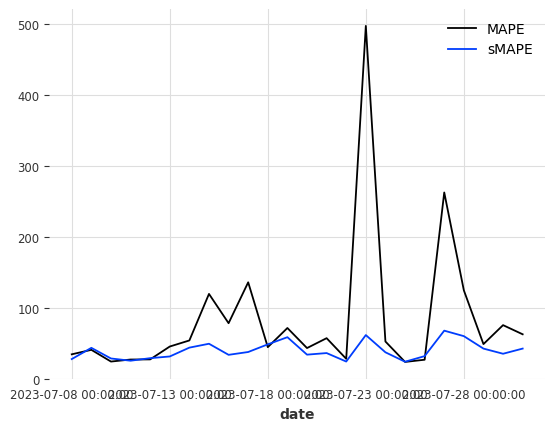

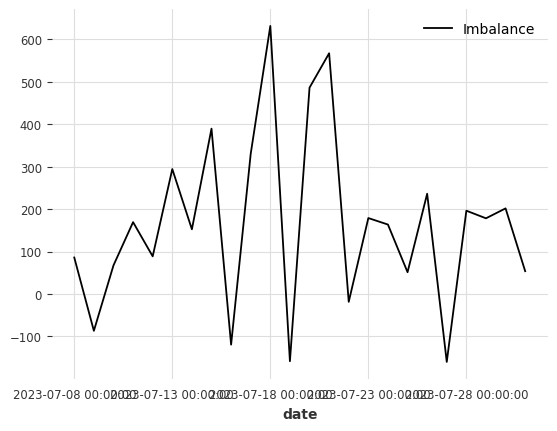

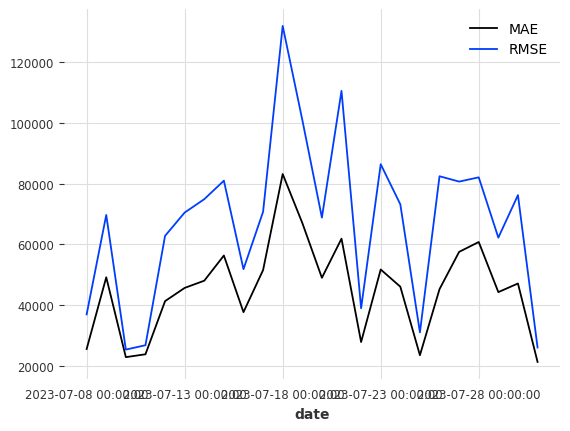

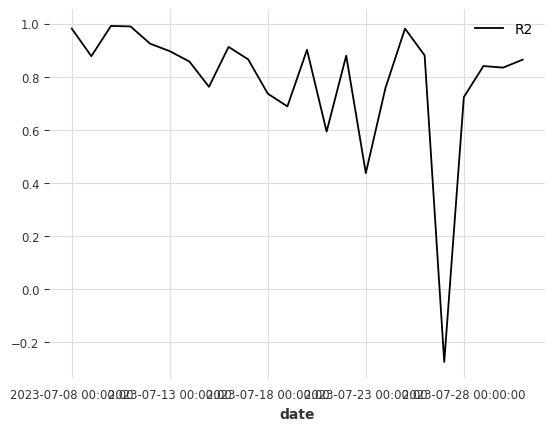

In [126]:
baseline_metrics.iloc[:-1].set_index('date')[['MAPE', 'sMAPE']].plot()
baseline_metrics.iloc[:-1].set_index('date')[['Imbalance']].plot()
baseline_metrics.iloc[:-1].set_index('date')[['MAE', 'RMSE']].plot()
baseline_metrics.iloc[:-1].set_index('date')[['R2']].plot()

Text(0.5, 0, 'Time')

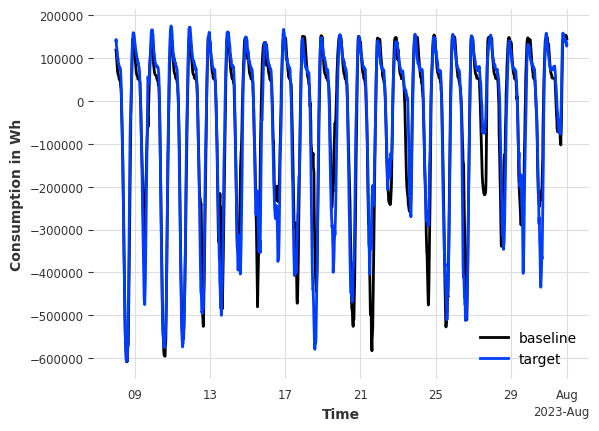

In [118]:
import matplotlib.pyplot as plt

# full_ts = ts_semantic.stack(ts_baseline['gross_predicted'].with_columns_renamed('gross_predicted', 'baseline')).with_columns_renamed(['gross_actuals','gross_predicted'], ['target', 'semantic'])
full_ts = ts_baseline.with_columns_renamed(['gross_actuals','gross_predicted'], ['target', 'baseline'])
ax = full_ts[0:-1].plot()
ax.set_ylabel('Consumption in Wh')
ax.set_xlabel('Time')

In [47]:
from darts.metrics.metrics import mae, mape, rmse, smape, r2_score

def get_metrics(_target, _predicted):
    # sMAPE
    smape_ = smape(_target, _predicted)
    mape_ = mape(_target, _predicted)
    mae_ = mae(_target, _predicted)
    # RMSE
    rmse_ = rmse(_target, _predicted)
    r2_ = r2_score(_target, _predicted)

    print(f'''
        SMAPE {round(smape_, 3)}
        MAPE  {round(mape_, 3)}
        MAE   {round(mae_, 3)}
        RMSE  {round(rmse_, 3)}
        R2    {round(r2_, 3)}
        ''')
    

get_metrics(full_ts['target'], full_ts['semantic'])
get_metrics(full_ts['target'], full_ts['baseline'])


        SMAPE 49.552
        MAPE  66.426
        MAE   48414.126
        RMSE  70101.032
        R2    0.874
        

        SMAPE 49.273
        MAPE  85.93
        MAE   52130.492
        RMSE  78998.325
        R2    0.84
        


In [5]:
pv_07 = pd.read_csv('../data/2023_07_cleaned_pv.csv', parse_dates=['readingdate']).set_index('readingdate')
non_pv_07 = pd.read_csv('../data/2023_07_cleaned_non_pv.csv', parse_dates=['readingdate']).set_index('readingdate')
# ts = TimeSeries.from_dataframe(ddf)
# ts.time_index.tz_localize('Europe/Amsterdam')

pv_07.index = pv_07.index.tz_localize(None).tz_localize(pytz.utc).tz_convert(AMS_TZ)
non_pv_07.index = non_pv_07.index.tz_localize(None).tz_localize(pytz.utc).tz_convert(AMS_TZ)

## Setting thresholds for business rules

In [33]:
import pandas as pd
from darts.timeseries import TimeSeries
import numpy as np
from scipy.constants import convert_temperature

import pytz

In [47]:
val_df = pd.read_csv('../data/2023_07_cleaned_pv.csv', parse_dates=['readingdate']).set_index('readingdate')
val_df = TimeSeries.from_dataframe(val_df, freq='15min')

actuals_df = pd.read_csv('../data/2023-04_to_08-amsterdam-actuals_filled_gaps.csv', parse_dates=['datetime_from']).set_index('datetime_from')[[ 'wind_speed', 'global_radiation', 'air_pressure', 'air_temperature', 'relative_humidity' ]]
actuals_df = actuals_df.resample('15min').mean()
actuals_df['temperature_c'] = actuals_df['air_temperature'].apply(lambda x: convert_temperature(x, 'K', 'C'))
actuals_df = TimeSeries.from_dataframe(actuals_df, freq='15min')

forecasts_df = pd.read_csv('../data/2023_weather_data_06_run_summer_from_04_to_08.csv', parse_dates=['valid_datetime']).set_index('valid_datetime')[[ 'wind_speed_10m', 'grad_accum_ground_0m', 'pres_instant_ground_0m', 't_instant_ground_2m', 'r_instant_ground_2m' ]]
forecasts_df = forecasts_df.resample('15min').ffill()
forecasts_df = TimeSeries.from_dataframe(forecasts_df,freq='15min')

prices = pd.read_csv('../data/2023-04_to_08_prices.csv', parse_dates=['DELIVERY_DATETIME']).set_index('DELIVERY_DATETIME')
prices.index = prices.index.tz_convert(pytz.timezone('Europe/Amsterdam')).tz_localize(None)
prices = TimeSeries.from_dataframe(prices, freq='15min')
prices = prices[val_df.time_index.min():val_df.time_index.max()]

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


In [103]:
import holidays
import datetime

hl = holidays.country_holidays('NL', years=2023)

for ptr in hl.items():
    print(ptr)

d = datetime.date(2023, 11, 4)
d in hl

(datetime.date(2023, 1, 1), 'Nieuwjaarsdag')
(datetime.date(2023, 4, 9), 'Eerste paasdag')
(datetime.date(2023, 4, 10), 'Tweede paasdag')
(datetime.date(2023, 4, 27), 'Koningsdag')
(datetime.date(2023, 5, 18), 'Hemelvaartsdag')
(datetime.date(2023, 5, 28), 'Eerste Pinksterdag')
(datetime.date(2023, 5, 29), 'Tweede Pinksterdag')
(datetime.date(2023, 12, 25), 'Eerste Kerstdag')
(datetime.date(2023, 12, 26), 'Tweede Kerstdag')


False

In [85]:
# IMBALANCE_SHORT_EUR_MWH,IMBALANCE_LONG_EUR_MWH,SPOT_EUR_MWH
# Ensure the price columns are numpy arrays
imbalance_short = prices['IMBALANCE_SHORT_EUR_MWH'].values()
imbalance_long = prices['IMBALANCE_LONG_EUR_MWH'].values()
spot_price = prices['SPOT_EUR_MWH'].values()

val = val_df.values()
# Use np.where to calculate the imbalance result
ib_result = np.where(
    val < 0,
    val * (imbalance_short - spot_price) / 1000,
    val * (imbalance_long - spot_price) / 1000
)

ib_result
    

array([[   -0.     ],
       [-3868.37654],
       [-4026.26637],
       ...,
       [-9241.59696],
       [-4011.23729],
       [-3029.9703 ]])

<Axes: xlabel='datetime_from'>

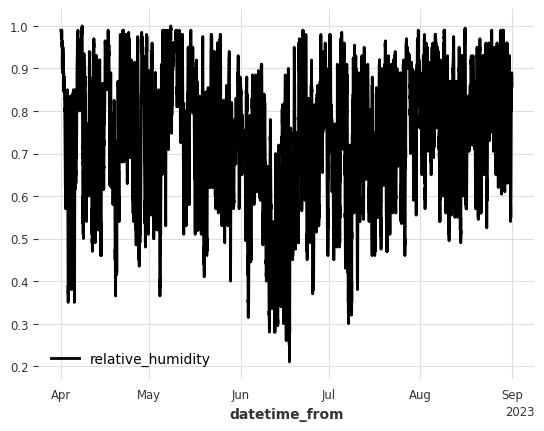

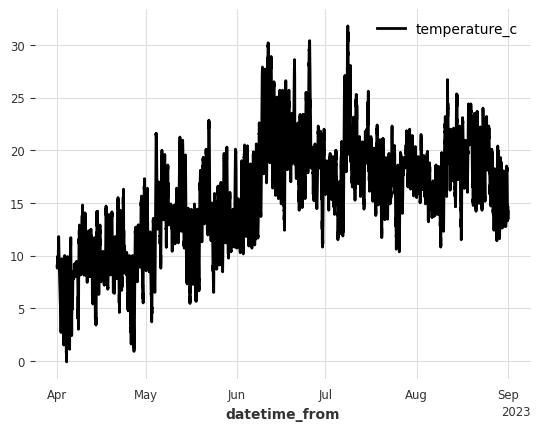

In [24]:
actuals_df[['relative_humidity']].plot()
actuals_df[['temperature_c']].plot(new_plot=True)

In [58]:
val_df = pd.read_csv('./2023_06_cleaned_pv.csv', parse_dates=['readingdate']).set_index('readingdate')
val_df = TimeSeries.from_dataframe(val_df, freq='15min')
# val_df.add_datetime_attribute('weekday', one_hot=True)

actuals_df = pd.read_csv('./2023-06-amsterdam-actuals.csv', parse_dates=['datetime_from']).set_index('datetime_from')[['wind_speed', 'global_radiation', 'air_pressure', 'air_temperature']]
actuals_df = actuals_df.resample('15min').mean()
actuals_df = TimeSeries.from_dataframe(actuals_df, freq='15min')

forecasts_df = pd.read_csv('../2023_weather_data_06_run_summer.csv', parse_dates=['valid_datetime']).set_index('valid_datetime')[['wind_speed_10m', 'grad_accum_ground_0m', 'pres_instant_ground_0m', 't_instant_ground_2m']]
forecasts_df = forecasts_df.resample('15min').ffill()
forecasts_df = TimeSeries.from_dataframe(forecasts_df,freq='15min')

# scaling
weather_forecast_scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
weather_actuals_scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))
smart_meter_scaler = Scaler(MinMaxScaler(feature_range=(0, 1)))

val_df = smart_meter_scaler.fit_transform(val_df)
actuals_df = weather_actuals_scaler.fit_transform(actuals_df)
forecasts_df = weather_forecast_scaler.fit_transform(forecasts_df)


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


### Explainability

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

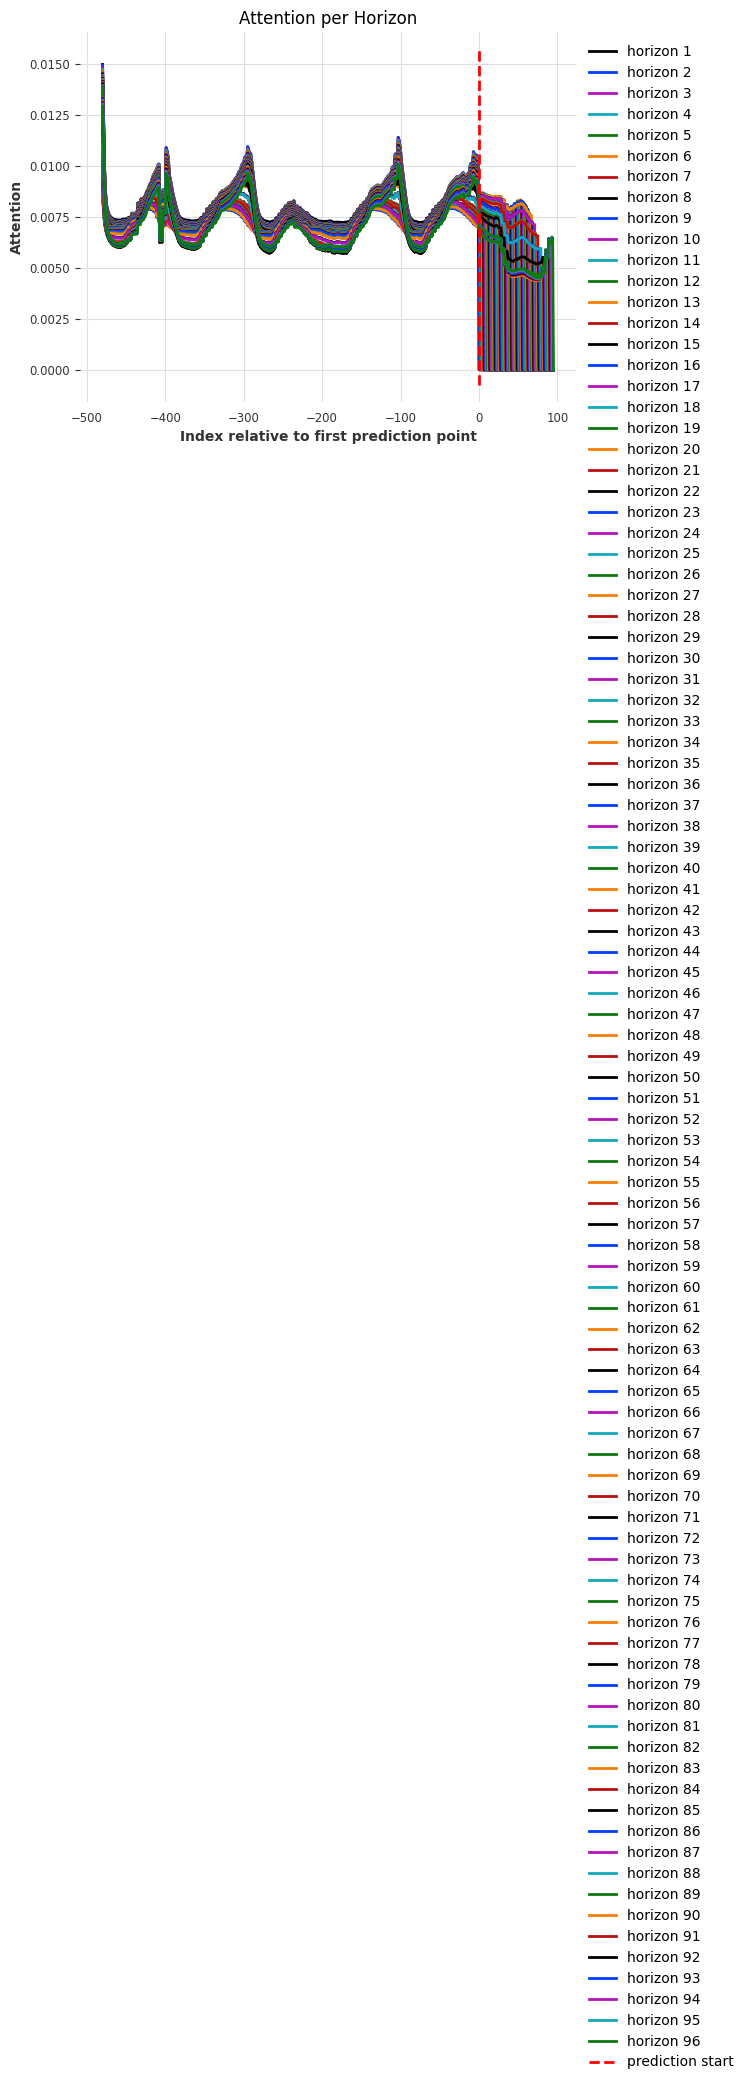

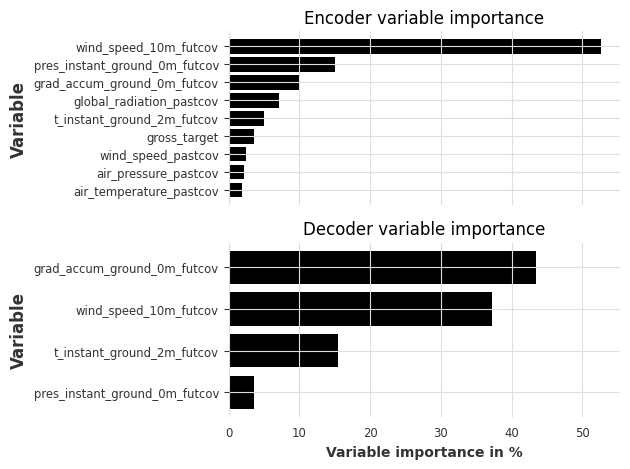

In [88]:
from darts.explainability.tft_explainer import TFTExplainer

explainer = TFTExplainer(model)
results = explainer.explain()
# plot the results
explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)

## Finding feature columns from tensor training batches

In [233]:
from os import listdir
from os.path import isfile, join
batch_path = '../debug'
onlyfiles = [f for f in listdir(batch_path) if isfile(join(batch_path, f)) and not "encode" in f]
onlyfiles.sort()
list(enumerate(onlyfiles))

[(0, '0_batch_00_tensor_00_slice.csv'),
 (1, '0_batch_01_tensor_00_slice.csv'),
 (2, '0_batch_01_tensor_01_slice.csv'),
 (3, '0_batch_01_tensor_02_slice.csv'),
 (4, '0_batch_01_tensor_03_slice.csv'),
 (5, '0_batch_02_tensor_00_slice.csv'),
 (6, '0_batch_02_tensor_01_slice.csv'),
 (7, '0_batch_02_tensor_02_slice.csv'),
 (8, '0_batch_02_tensor_03_slice.csv'),
 (9, '0_batch_03_tensor_00_slice.csv'),
 (10, '0_batch_03_tensor_01_slice.csv'),
 (11, '0_batch_03_tensor_02_slice.csv'),
 (12, '0_batch_03_tensor_03_slice.csv')]

In [226]:
from os import listdir
from os.path import isfile, join
batch_path = '../debug'
onlyfiles = [f for f in listdir(batch_path) if isfile(join(batch_path, f)) and "encode" in f]
onlyfiles.sort()
list(enumerate(onlyfiles))

[(0, '0_encoded_batch_00_tensor_00_slice.csv'),
 (1, '0_encoded_batch_01_tensor_00_slice.csv'),
 (2, '0_encoded_batch_01_tensor_01_slice.csv'),
 (3, '0_encoded_batch_01_tensor_02_slice.csv'),
 (4, '0_encoded_batch_01_tensor_03_slice.csv'),
 (5, '0_encoded_batch_01_tensor_04_slice.csv'),
 (6, '0_encoded_batch_01_tensor_05_slice.csv'),
 (7, '0_encoded_batch_02_tensor_00_slice.csv'),
 (8, '0_encoded_batch_02_tensor_01_slice.csv'),
 (9, '0_encoded_batch_02_tensor_02_slice.csv'),
 (10, '0_encoded_batch_02_tensor_03_slice.csv'),
 (11, '0_encoded_batch_02_tensor_04_slice.csv'),
 (12, '0_encoded_batch_02_tensor_05_slice.csv'),
 (13, '0_encoded_batch_03_tensor_00_slice.csv'),
 (14, '0_encoded_batch_03_tensor_01_slice.csv'),
 (15, '0_encoded_batch_03_tensor_02_slice.csv'),
 (16, '0_encoded_batch_03_tensor_03_slice.csv'),
 (17, '0_encoded_batch_03_tensor_04_slice.csv'),
 (18, '0_encoded_batch_03_tensor_05_slice.csv')]

In [227]:
dfs = [pd.read_csv(f'{batch_path}/{f}') for f in onlyfiles]
dfs[0]

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,-1340166.0,-1366976.0,-1365573.0,-1367162.0,-1373745.0,-1372186.0,-1365277.0,-1359439.0,-1345337.0,-1325772.0,...,-720031.0,-794700.0,-867931.0,-921936.0,-979769.0,-1027472.0,-1084847.0,-1142136.0,-1190073.0,-1226295.0
1,-236143.0,-183667.0,-106157.0,-59735.0,-5163.0,59281.0,123104.0,191534.0,221138.0,253393.0,...,-1121395.0,-1062007.0,-997049.0,-905651.0,-822101.0,-716237.0,-600674.0,-481484.0,-382095.0,-301183.0
2,182359.0,179540.0,180954.0,179379.0,184732.0,177152.0,175332.0,170774.0,172628.0,161367.0,...,252485.0,245633.0,234950.0,232693.0,230373.0,227055.0,217262.0,217192.0,212594.0,207518.0
3,348644.0,336072.0,319762.0,302786.0,289459.0,275334.0,258057.0,251948.0,247520.0,228155.0,...,347143.0,374271.0,412872.0,416203.0,429857.0,425806.0,412607.0,419068.0,402314.0,391923.0
4,-1294957.0,-1307393.0,-1296323.0,-1269000.0,-1230496.0,-1197892.0,-1169721.0,-1104926.0,-1067746.0,-1005867.0,...,-1051129.0,-1091043.0,-1122540.0,-1153344.0,-1180048.0,-1196500.0,-1201980.0,-1217071.0,-1208759.0,-1205302.0
5,-630937.0,-673785.0,-702443.0,-747582.0,-780456.0,-804592.0,-831085.0,-874144.0,-926155.0,-948688.0,...,-663671.0,-733424.0,-808218.0,-882345.0,-955641.0,-1021346.0,-1071884.0,-1123415.0,-1169929.0,-1198840.0
6,136147.0,102376.0,66139.0,24455.0,-15983.0,-59956.0,-107402.0,-156366.0,-203273.0,-257469.0,...,189846.0,185264.0,181790.0,178052.0,173986.0,173277.0,171359.0,167948.0,163463.0,152500.0
7,362509.0,380787.0,382413.0,395999.0,396704.0,384477.0,364195.0,360063.0,343844.0,327960.0,...,-96997.0,-20013.0,29481.0,86015.0,152649.0,203519.0,252803.0,293253.0,328044.0,361688.0
8,-374038.0,-449470.0,-527296.0,-609676.0,-700696.0,-780958.0,-858474.0,-945197.0,-1020128.0,-1080271.0,...,164217.0,152260.0,136485.0,117069.0,78474.0,45275.0,2944.0,-53753.0,-112664.0,-155276.0
9,-1241475.0,-1294753.0,-1340166.0,-1366976.0,-1365573.0,-1367162.0,-1373745.0,-1372186.0,-1365277.0,-1359439.0,...,-569585.0,-643326.0,-720031.0,-794700.0,-867931.0,-921936.0,-979769.0,-1027472.0,-1084847.0,-1142136.0


In [232]:
dfs[5].describe()

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,2.812500,2.843750,2.875000,2.875000,2.875000,2.875000,2.875000,2.906250,2.937500,2.968750,...,2.937500,2.937500,2.937500,2.937500,2.968750,3.000000,3.000000,3.000000,3.000000,2.812500
std,1.925005,1.919499,1.930235,1.930235,1.930235,1.930235,1.930235,1.906853,1.865433,1.908967,...,1.982789,1.982789,1.982789,1.982789,1.975403,1.934408,1.934408,1.934408,1.934408,1.925005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000


In [211]:
[print(d.shape) for d in dfs]

(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 672)
(32, 96)
(32, 96)
(32, 96)
(32, 96)
(32, 96)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [141]:
n = dfs[5]
m = dfs[9]
m

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.834593,1.834593,1.988579,1.988579,1.988579,1.988579,1.870757,1.870757,1.870757,1.870757,...,1.249977,1.249977,1.249977,1.249977,1.560027,1.560027,1.560027,1.560027,1.808022,1.808022
1,3.406696,3.406696,3.406696,3.406696,3.210056,3.210056,3.210056,3.210056,3.283361,3.283361,...,4.145731,4.145731,4.206111,4.206111,4.206111,4.206111,3.875983,3.875983,3.875983,3.875983
2,5.525506,5.525506,5.396968,5.396968,5.396968,5.396968,5.127884,5.127884,5.127884,5.127884,...,4.835532,4.835532,4.835532,4.835532,5.272175,5.272175,5.272175,5.272175,5.595923,5.595923
3,1.710040,1.710040,1.710040,1.916040,1.916040,1.916040,1.916040,2.167682,2.167682,2.167682,...,4.143808,4.204272,4.204272,4.204272,4.204272,3.516125,3.516125,3.516125,3.516125,3.049135
4,2.479171,2.479171,2.479171,2.479171,2.331807,2.331807,2.331807,2.331807,1.753839,1.753839,...,4.787810,4.787810,1.741210,1.741210,1.741210,1.741210,1.747325,1.747325,1.747325,1.747325
5,4.317928,4.317928,4.317928,4.317928,3.835572,3.835572,3.835572,3.835572,3.944538,3.944538,...,2.745438,2.745438,3.135687,3.135687,3.135687,3.135687,2.737386,2.737386,2.737386,2.737386
6,2.654253,2.914748,2.914748,2.914748,2.914748,3.220103,3.220103,3.220103,3.220103,3.858098,...,3.461101,3.461101,3.461101,3.094804,3.094804,3.094804,3.094804,3.274557,3.274557,3.274557
7,2.555571,2.031704,2.031704,2.031704,2.031704,2.546020,2.546020,2.546020,2.546020,2.845944,...,2.091621,2.091621,2.091621,2.316888,2.316888,2.316888,2.316888,2.138129,2.138129,2.138129
8,2.355386,2.355386,2.355386,2.355386,1.430747,1.430747,1.430747,1.430747,1.156683,1.156683,...,2.479171,2.479171,2.331807,2.331807,2.331807,2.331807,1.753839,1.753839,1.753839,1.753839
9,3.912131,3.912131,3.463387,3.463387,3.463387,3.463387,3.129776,3.129776,3.129776,3.129776,...,5.525506,5.525506,5.525506,5.525506,5.396968,5.396968,5.396968,5.396968,5.127884,5.127884


<Axes: >

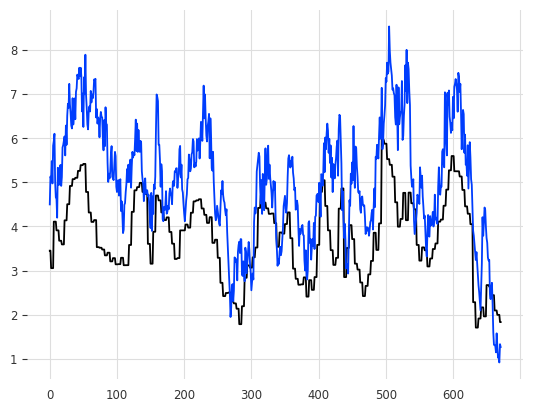

In [139]:
n.iloc[0,:].plot()
m.iloc[0,:].plot()

In [10]:
from darts.timeseries import TimeSeries

smart_meter_tss = TimeSeries.from_dataframe(sm[0])

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


In [46]:
sm

,gross
readingdate,
2023-05-31 23:00:00+02:00,0
2023-05-31 23:15:00+02:00,363576
2023-05-31 23:30:00+02:00,352240
2023-05-31 23:45:00+02:00,331535
2023-06-01 00:00:00+02:00,312404
...,...
2023-06-30 22:45:00+02:00,364599
2023-06-30 23:00:00+02:00,357906
2023-06-30 23:15:00+02:00,354801


In [48]:
from astral import LocationInfo
import datetime as dt
import pytz
from astral.sun import sun

city = LocationInfo("Amsterdam", "Netherlands", "Europe/Amsterdam")
city.observer

ams = pytz.timezone('Europe/Amsterdam')
print(ams)


d = (dt.datetime.strptime('2023-05-31 21:00+0000', "%Y-%m-%d %H:%M%z")).astimezone(ams)
print(d)
sm.index = sm.index.tz_convert(ams)

s = sun(city.observer, date=sm.index[0])
s

Europe/Amsterdam
2023-05-31 23:00:00+02:00


{'dawn': datetime.datetime(2023, 5, 31, 5, 4, 12, 509423, tzinfo=<DstTzInfo 'Europe/Amsterdam' CEST+2:00:00 DST>),
 'sunrise': datetime.datetime(2023, 5, 31, 5, 50, 9, 217728, tzinfo=<DstTzInfo 'Europe/Amsterdam' CEST+2:00:00 DST>),
 'noon': datetime.datetime(2023, 5, 31, 11, 57, 44, tzinfo=datetime.timezone.utc),
 'sunset': datetime.datetime(2023, 5, 31, 22, 5, 51, 564686, tzinfo=<DstTzInfo 'Europe/Amsterdam' CEST+2:00:00 DST>),
 'dusk': datetime.datetime(2023, 5, 31, 22, 52, 1, 652368, tzinfo=<DstTzInfo 'Europe/Amsterdam' CEST+2:00:00 DST>)}

In [101]:
def get_part_of_day(s):
    i = s.name
    sun_info = sun(city.observer, date=i.date())
    sunrise = sun_info['sunrise'].astimezone(ams).time()
    sunset = sun_info['sunset'].astimezone(ams).time()

    
    if i.time() < sunrise or i.time() > sunset:
        return 'Night'
    elif sunrise <= i.time() < dt.time(9, 0, 0):
        return 'Morning'
    elif dt.time(9, 0, 0) <= i.time() < dt.time(13,0,0):
        return 'Midday'
    elif dt.time(13, 0, 0) <= i.time() < dt.time(17, 0, 0):
        return 'Afternoon'
    else:
        return 'Evening'

sm['part_of_day'] = sm.apply(lambda x : get_part_of_day(x), axis=1)
# sm.iloc[700:750]

AttributeError: 'Series' object has no attribute 'columns'

In [123]:
sm['has_pv'] = True
sm

,gross,part_of_day,has_pv
readingdate,,,
2023-05-31 23:00:00+02:00,0,Night,True
2023-05-31 23:15:00+02:00,363576,Night,True
2023-05-31 23:30:00+02:00,352240,Night,True
2023-05-31 23:45:00+02:00,331535,Night,True
2023-06-01 00:00:00+02:00,312404,Night,True
...,...,...,...
2023-06-30 22:45:00+02:00,364599,Night,True
2023-06-30 23:00:00+02:00,357906,Night,True
2023-06-30 23:15:00+02:00,354801,Night,True


In [203]:
wa

,wind_speed_10m,grad_accum_ground_0m,pres_instant_ground_0m,t_instant_ground_2m
valid_datetime,,,,
2023-04-01 00:00:00+02:00,5.080210,0.0,98975.190,282.15723
2023-04-01 00:15:00+02:00,5.080210,0.0,98975.190,282.15723
2023-04-01 00:30:00+02:00,5.080210,0.0,98975.190,282.15723
2023-04-01 00:45:00+02:00,5.080210,0.0,98975.190,282.15723
2023-04-01 01:00:00+02:00,4.670426,0.0,98986.190,282.03906
...,...,...,...,...
2023-07-31 22:00:00+02:00,3.308534,0.0,100009.875,289.52185
2023-07-31 22:15:00+02:00,3.308534,0.0,100009.875,289.52185
2023-07-31 22:30:00+02:00,3.308534,0.0,100009.875,289.52185


In [206]:
past_covariates = sm[['part_of_day', 'has_pv']]
TimeSeries.from_dataframe(wa).stack(TimeSeries.from_dataframe(past_covariates))

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(Europe/Amsterdam)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(Europe/Amsterdam)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


ValueError: could not convert string to float: 'Night'

In [192]:
from darts.timeseries import TimeSeries

static_cov = pd.DataFrame([[1]], columns=["has_pv"])
past_covariates = sm[['part_of_day', 'has_pv']]

ts = TimeSeries.from_dataframe(sm, value_cols=['gross'])
# ts_multi = ts.stack(ts)
ts.with_static_covariates(static_cov).static_covariates




The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(Europe/Amsterdam)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


static_covariates,has_pv
component,
gross,1.0


In [17]:
from darts.timeseries import TimeSeries
import numpy as np

In [15]:
import pandas as pd
df = pd.read_csv('../data/2023_05_cleaned_pv.csv', parse_dates=['readingdate']).set_index('readingdate')
df_1 = pd.read_csv('../data/2023_06_cleaned_pv.csv', parse_dates=['readingdate']).set_index('readingdate')

In [18]:
smart_meter_tss = [TimeSeries.from_dataframe(s).astype(np.float32) for s in [df, df_1]]

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


[<Axes: xlabel='readingdate'>, <Axes: xlabel='readingdate'>]

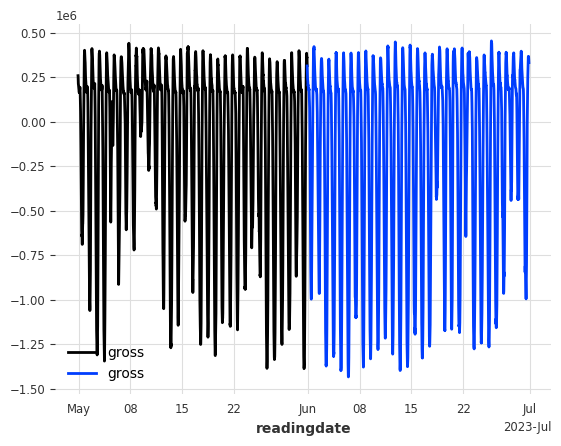

In [20]:
[s.plot() for s in smart_meter_tss]

In [11]:
df.describe()
# df_1.plot()

,gross
count,2.976000e+03
mean,-1.286595e+05
std,4.928264e+05
min,-1.388359e+06
25%,-4.848232e+05
50%,1.317410e+05
75%,2.270318e+05
max,4.400010e+05


In [4]:
df

'../data/data/2023_05_cleaned_pv.csv'

In [ ]:

ts_multi.with_static_covariates(multi)
# TimeSeries.from_dataframe(sm, value_cols=['gross']).with_static_covariates(sm['part_of_day']).with_static_covariates(sm['has_pv'])

In [11]:
smart_meter_tss.with_static_covariates

<TimeSeries (DataArray) (readingdate: 2884, component: 1, sample: 1)> Size: 23kB
array([[[     0.]],

       [[363576.]],

       [[352240.]],

       ...,

       [[354801.]],

       [[346129.]],

       [[331224.]]])
Coordinates:
  * readingdate  (readingdate) datetime64[ns] 23kB 2023-05-31T21:00:00 ... 20...
  * component    (component) object 8B 'gross'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [5]:
# 2023_06_cleaned_pv.csv 
# 2023-06-amsterdam-actuals.csv 
# ../2023_weather_data_06_run_summer.csv
import yaml
from src.neuro_symbolic_demand_forecasting.main_train import _load_csvs

model_config = {}
with open('../model_config.yaml', 'r') as file:
    model_config = yaml.safe_load(file)

sm, wa, wf = _load_csvs(model_config, ['2023_06_cleaned_pv.csv'],['../2023_weather_data_06_run_summer.csv'],  ['2023-06-amsterdam-actuals.csv'])

/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.11/lib/python3.11/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [112]:
readings = dfs[0]

In [119]:
# checking the start values of 0thtensor_0th_slice
print(sm[sm['gross']== 28602.0])
print(sm[sm['gross']== 184896.0])
print(sm[sm['gross']== 382217.0])
print(sm[sm['gross']== -400591.0])
print(sm[sm['gross']== -1151372.0])

                           gross
readingdate                     
2023-06-08 05:30:00+00:00  28602
                            gross
readingdate                      
2023-06-02 03:00:00+00:00  184896
                            gross
readingdate                      
2023-06-07 20:15:00+00:00  382217
                            gross
readingdate                      
2023-06-10 16:00:00+00:00 -400591
                             gross
readingdate                       
2023-06-08 14:00:00+00:00 -1151372
